# Mail scraping using imapclient

__In this notebook I will be using the python package `IMAPClient` to scrape my emails from amazon, and `seaborn` to plot the amount of money I have spent on amazon over time.__

In [1]:
from imapclient import IMAPClient
import email
from dotenv import load_dotenv, find_dotenv
import os
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [3]:
load_dotenv(find_dotenv())

True

In [4]:
server = IMAPClient(host='imap.gmail.com', 
                    ssl=True,
                    port=993,
                    use_uid=True)
server.login(os.environ["mail_username"], os.environ["mail_pass_app_specific"])

b'james.twose2711@gmail.com authenticated (Success)'

In [5]:
select_info = server.select_folder('INBOX')
print('%d messages in INBOX' % select_info[b'EXISTS'])

27209 messages in INBOX


In [6]:
messages = server.search(['FROM', 'auto-bevestiging@amazon.nl'])
print("%d messages from Amazon purchases" % len(messages))

18 messages from Amazon purchases


In [7]:
df = pd.DataFrame()
for msgid, data in server.fetch(messages, ['ENVELOPE']).items():
    envelope = data[b'ENVELOPE']
    # print('ID #%d: "%s" received %s' % (msgid, envelope.subject.decode(), envelope.date))
    tmp_df = pd.DataFrame({
    "msgID": msgid,
    "subject": envelope.subject.decode(),
    "date_recieved": envelope.date
             }, index=[0])
    df = pd.concat([df, tmp_df])

In [8]:
_ = df.reset_index(inplace=True, drop=True)

In [9]:
response = server.fetch(messages, ['RFC822', 'BODY[TEXT]'])

In [10]:
body_df = pd.DataFrame()
price_search_term = "Order Total:                     EUR "

for msgid, data in response.items():
    parsedEmail = email.message_from_string(data[b'RFC822'].decode("utf-8") )
    body = email.message_from_string(data[b'BODY[TEXT]'].decode("utf-8"))
    parsedBody = parsedEmail.get_payload(0)
    # print(parsedBody)

    for part in parsedBody.walk():
        if part.get_content_type() == "text/plain":
            # print(part)
            body_str = str(part)
            if body_str.find(price_search_term) > 0:
                price = float(body_str.split(price_search_term)[1].split("\n")[0].replace(",", "."))
            elif body_str.find("Totaal bestelling inclusief btw:     EUR ") > 0:
                price = float(body_str.split("Totaal bestelling inclusief btw:     EUR ")[1].split("\n")[0].replace(",", "."))
            elif body_str.find("Totaal bestelling inclusief btw: EUR ") > 0:
                price = float(body_str.split("Totaal bestelling inclusief btw: EUR ")[1].split("\n")[0].replace(",", "."))
            else:
                price = float(body_str.split("Besteltotaal:    EUR ")[1].split("\n")[0].replace(",", "."))
            tmp_df = pd.DataFrame({
                "msgID": msgid,
                "message_body": body_str,
                "price": price,
             }, index=[0])
            body_df = pd.concat([body_df, tmp_df])

In [11]:
_ = body_df.reset_index(inplace=True, drop=True)

In [12]:
plot_df = pd.merge(df, body_df, on = "msgID")

In [13]:
server.logout()

b'LOGOUT Requested'

In [14]:
plot_df

,msgID,subject,date_recieved,message_body,price
0,21108,"Je Amazon.nl-bestelling van ""Silentnight 3-zon...",2020-03-15 23:02:02,Content-Type: text/plain; charset=utf-8\nConte...,238.16
1,24128,Je bestelling bij Amazon.nl met bestelnr. 405-...,2020-09-04 13:24:06,Content-Type: text/plain; charset=utf-8\nConte...,17.48
2,24401,Je bestelling bij Amazon.nl met bestelnr. 407-...,2020-09-17 17:34:10,Content-Type: text/plain; charset=utf-8\nConte...,37.00
3,24435,Je bestelling bij Amazon.nl met bestelnr. 407-...,2020-09-18 15:50:10,Content-Type: text/plain; charset=utf-8\nConte...,22.30
4,26195,Je bestelling bij Amazon.nl met bestelnr. 407-...,2020-12-04 22:47:27,Content-Type: text/plain; charset=utf-8\nConte...,23.99
5,26800,Je bestelling bij Amazon.nl met bestelnr. 407-...,2020-12-29 00:01:45,Content-Type: text/plain; charset=utf-8\nConte...,58.97
6,26936,Je bestelling bij Amazon.nl met bestelnr. 403-...,2021-01-03 21:05:51,Content-Type: text/plain; charset=utf-8\nConte...,124.99
7,27910,Je bestelling bij Amazon.nl met bestelnr. 406-...,2021-02-06 18:13:37,Content-Type: text/plain; charset=utf-8\nConte...,203.35
8,28416,Je bestelling bij Amazon.nl met bestelnr. 406-...,2021-02-24 20:55:29,Content-Type: text/plain; charset=utf-8\nConte...,26.44
9,28428,Je bestelling bij Amazon.nl met bestelnr. 406-...,2021-02-25 09:31:36,Content-Type: text/plain; charset=utf-8\nConte...,45.50


In [15]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   msgID          18 non-null     int64         
 1   subject        18 non-null     object        
 2   date_recieved  18 non-null     datetime64[ns]
 3   message_body   18 non-null     object        
 4   price          18 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 864.0+ bytes


In [16]:
plot_df=plot_df.assign(**{"Cumulative Price": lambda d: d["price"].cumsum()})

In [21]:
# _ = plt.figure(figsize=(15, 6))
# _ = sns.lineplot(data=plot_df,
#                 x="date_recieved",
#                 y="price")
# _ = sns.scatterplot(data=plot_df,
#                 x="date_recieved",
#                 y="price")
# _ = plt.title("The amount of money spent on amazon over time")
# _ = plt.xlabel("Date")
# _ = plt.ylabel("Price")
# _ = sns.despine()

In [20]:
# _ = plt.figure(figsize=(15, 6))
# _ = sns.lineplot(data=plot_df,
#                 x="date_recieved",
#                 y="Cumulative Price")
# _ = sns.scatterplot(data=plot_df,
#                 x="date_recieved",
#                 y="Cumulative Price")
# _ = plt.title("The cumulative sum of money spent on amazon over time")
# _ = plt.xlabel("Date")
# _ = sns.despine()

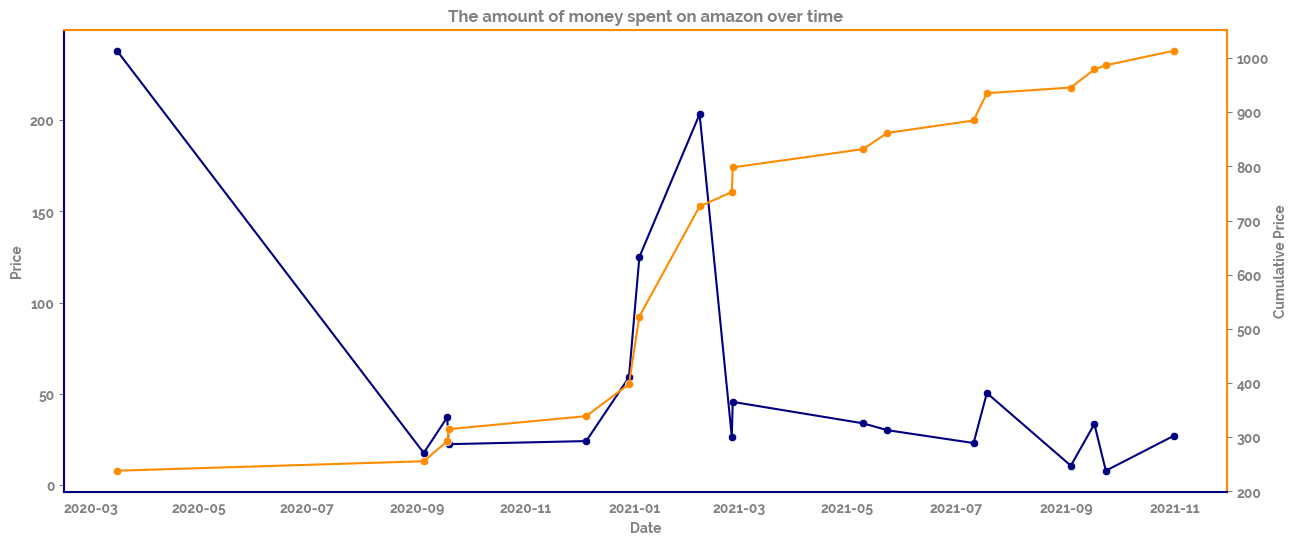

In [19]:
_ = plt.figure(figsize=(15, 6))
_ = sns.lineplot(data=plot_df,
                x="date_recieved",
                y="price",
                color="navy"
                )
_ = sns.scatterplot(data=plot_df,
                x="date_recieved",
                y="price",
                    color="navy"
                   )
_ = plt.title("The amount of money spent on amazon over time")
_ = plt.xlabel("Date")
_ = plt.ylabel("Price")

ax2 = plt.twinx()

_ = sns.lineplot(data=plot_df,
                x="date_recieved",
                y="Cumulative Price",
                 color="darkorange",
                ax=ax2)
_ = sns.scatterplot(data=plot_df,
                x="date_recieved",
                y="Cumulative Price",
                    color="darkorange",
                   ax=ax2)

ax2.spines['left'].set_color("navy")
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_color("navy")
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['right'].set_color("darkorange")
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['top'].set_color("darkorange")
ax2.spines['top'].set_linewidth(1.5)

# _ = sns.despine()